### Runtime: 30s

In [1]:
# Standard library imports
import gc

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns

from scipy.stats import chi2, chi2_contingency, fisher_exact


In [2]:
# Constants
INPUT_DATA_PATH = '../data/NSDUH_2015-2019.parquet'
OUTPUT_DATA_PATH = '../data/clean_NSDUH_2015-2019_V2.parquet'
COLUMNS_TO_LOAD = {
    "crkever": "Ever used crack cocaine.",
    "cocever": "Ever used cocaine.",
    "iralcfy": "Number of days alcohol was consumed in the past year.",
    "catag3": "Age group of the respondent.",
    "health": "General health condition of the respondent.",
    "irwrkstat": "Work status of the respondent.",
    "ireduhighst2": "Highest level of education completed.",
    "newrace2": "Race or ethnicity of the respondent.",
    "irsex": "Sex of the respondent.",
    "irpinc3": "Income range of the household.",
    "irki17_2": "Number of children under 18 years old in the household.",
    "irmjfy": "Number of days marijuana was used in the past year.",
    "wrkdhrswk2": "Number of hours worked in the past week.",
    "irhhsiz2": "Number of people in the household.",
    "cig30use": "Number of days cigarettes were smoked in the past month.",
    "irherfy": "Number of days heroin was used in the past year.",
    "irmethamyfq": "Number of days methamphetamine was used in the past year.",
    "year": "Year of the survey.",
}
sns.set_theme(style="whitegrid", palette="muted") #  Налаштування стилю та кольорової палітри для Seaborn


In [3]:
def clear_memory():
    gc.collect()


In [4]:
try:
    parquet_metadata = pq.read_schema(INPUT_DATA_PATH)  # Читаємо схему
    available_columns = parquet_metadata.names  # Отримуємо назви колонок
except Exception as e:
    print(f"Помилка під час отримання списку колонок: {e}")


In [5]:
mapped_columns = {}
for col in list(COLUMNS_TO_LOAD.keys()):
    matched_column = next((c for c in available_columns if col.lower() in c.lower()), None)
    if matched_column:
        mapped_columns[col] = matched_column

# print("Відповідності колонок:")
# for original, mapped in mapped_columns.items():
#     print(f"{original} → {mapped}")

del parquet_metadata, available_columns
clear_memory()


In [6]:
# Оновлений список колонок після перевірки
COLUMNS_TO_LOAD = list(mapped_columns.values())

# Континуальні змінні
cont_cols = ["iralcfy", "irmjfy", "wrkdhrswk2", "irherfy", "irmethamyfq"]
cont_cols = [mapped_columns[col] for col in cont_cols if col in mapped_columns]
del mapped_columns
clear_memory()

# Ординальні змінні
ord_cols = [col for col in COLUMNS_TO_LOAD if col not in cont_cols]

# Функція для очищення даних у вигляді векторизованої логіки
def clean_column(series, continuous=False):
    # Значення, які потрібно замінити на NaN
    invalid_values = [-9, 85, 89, 985, 989] + (list(range(94, 100)) if not continuous else list(range(994, 1000)))
    # Значення, які потрібно замінити на 0
    zero_values = [91, 93] + ([991, 993] if continuous else [])

    # Замінюємо значення у стовпці
    series = series.where(~series.isin(invalid_values), np.nan)  # Замінюємо invalid_values на NaN
    series = series.where(~series.isin(zero_values), 0)         # Замінюємо zero_values на 0
    return series

try:
    # Завантаження відповідних колонок
    df = pd.read_parquet(INPUT_DATA_PATH, columns=COLUMNS_TO_LOAD)

    # Очищення континуальних змінних
    for col in cont_cols:
        df[col] = clean_column(df[col], continuous=True)

    # Очищення ординальних змінних
    for col in ord_cols:
        df[col] = clean_column(df[col])

    # Видалення рядків із пропущеними значеннями
    df = df.dropna()

    print(f"Дані успішно завантажено та очищено. Кількість рядків після очищення: {df.shape[0]:,}")
except Exception as e:
    print(f"Помилка під час завантаження та обробки даних: {e}")


Дані успішно завантажено та очищено. Кількість рядків після очищення: 139,106


In [7]:
df.head()

,crkever,cocever,iralcfy,catag3,health,irwrkstat,ireduhighst2,newrace2,irsex,irpinc3,irki17_2,irmjfy,wrkdhrswk2,irhhsiz2,cig30use,irherfy,irmethamyfq,year
1,1.0,1.0,52.0,4.0,1.0,1.0,8.0,7.0,1.0,2.0,3.0,364.0,40.0,4.0,0.0,0.0,0.0,2015.0
10,0.0,2.0,0.0,1.0,4.0,1.0,6.0,7.0,2.0,1.0,3.0,0.0,27.0,3.0,0.0,0.0,0.0,2015.0
12,0.0,2.0,52.0,3.0,1.0,1.0,10.0,1.0,2.0,4.0,2.0,0.0,38.0,5.0,0.0,0.0,0.0,2015.0
14,0.0,2.0,24.0,3.0,2.0,1.0,9.0,7.0,1.0,4.0,2.0,0.0,40.0,4.0,0.0,0.0,0.0,2015.0
16,0.0,2.0,0.0,4.0,1.0,2.0,2.0,7.0,2.0,2.0,2.0,0.0,35.0,3.0,0.0,0.0,0.0,2015.0


In [8]:
# Функція для очищення категорійних змінних
def clean_categorical_data(df, mappings):
    for col, mapping in mappings.items():
        if col in df.columns:
            df[col] = df[col].replace(mapping)
    return df

# Функція для очищення даних wrkdhrswk2
def clean_wrkdhrswk2(df):
    if "irwrkstat" in df.columns and "wrkdhrswk2" in df.columns:
        df.loc[(df["irwrkstat"] == 3) | (df["irwrkstat"] == 4), "wrkdhrswk2"] = 0
        df.loc[df["wrkdhrswk2"] == 61, "wrkdhrswk2"] = np.nan
    return df

# Функція для очищення impweeks
def clean_impweeks(df):
    if "impweeks" in df.columns:
        df["impweeks"] = df["impweeks"].replace({89: 0, 99: 0})
    return df

# Функція для очищення cig100lf
def clean_cig100lf(df):
    if "cig100lf" in df.columns:
        df["cig100lf"] = df["cig100lf"].replace({2: 0, 5: 0})
    return df

try:
    # Очищення wrkdhrswk2
    df = clean_wrkdhrswk2(df)

    # Очищення impweeks
    df = clean_impweeks(df)

    # Очищення бінарних категорійних змінних
    binary_mappings = {
        "cocever": {2: 0},
        "crkever": {2: 0},
        "mjever": {2: 0},
        "irsex": {2: 0}
    }
    df = clean_categorical_data(df, binary_mappings)

    # Очищення cig100lf
    df = clean_cig100lf(df)

    # Видалення зайвих змінних
    del binary_mappings, cont_cols, ord_cols
    clear_memory()

    print(f"Дані успішно завантажено та очищено. Кількість рядків після очищення: {df.shape[0]:,}")
except Exception as e:
    print(f"Помилка під час завантаження та обробки даних: {e}")

Дані успішно завантажено та очищено. Кількість рядків після очищення: 139,106


In [9]:
for col in COLUMNS_TO_LOAD:
    unique_values = np.sort(df[col].unique())
    try:
        unique_values = np.array([int(val) if not np.isnan(val) else val for val in unique_values])
    except TypeError:
        pass

    print(f"Column: {col}")
    print(unique_values)
    print("=" * 75, '\n')
del unique_values
clear_memory()

Column: crkever
[0 1]

Column: cocever
[0 1]

Column: iralcfy
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  90  92
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 116 117 118 119 120 121 123 124 125 126 129 130 131 132 133 134
 135 136 137 138 139 140 143 144 145 147 148 149 150 153 154 156 157 158
 159 160 162 164 165 168 170 171 175 176 179 180 185 186 190 192 193 196
 200 202 204 208 210 212 216 217 218 220 222 225 228 230 235 240 241 245
 250 251 252 256 259 260 261 264 265 270 271 275 276 280 285 288 289 290
 295 300 301 302 305 306 312 313 320 322 324 325 330 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 3

In [10]:
df.isna().sum()

crkever            0
cocever            0
iralcfy            0
catag3             0
health             0
irwrkstat          0
ireduhighst2       0
newrace2           0
irsex              0
irpinc3            0
irki17_2           0
irmjfy             0
wrkdhrswk2      5238
irhhsiz2           0
cig30use           0
irherfy            0
irmethamyfq        0
year               0
dtype: int64

In [11]:
df.dropna(inplace=True)
print(f'Clean DataFrame: \nRows = {df.shape[0]:,} | Columns = {df.shape[1]}')

Clean DataFrame: 
Rows = 133,868 | Columns = 18


# Creating our Target Column

In [12]:
# Створення нової цільової колонки
df["coccrkever"] = np.select(
    [
        (df["cocever"] == 1) | (df["crkever"] == 1),  # Якщо будь-яка з цих умов виконана
        (df["cocever"].isna()) & (df["crkever"].isna())  # Якщо всі значення NaN
    ],
    [
        1,  # Виконано хоча б одну умову
        np.nan  # Усі значення NaN
    ],
    default=0  # За замовчуванням 0, якщо жодна умова не виконана
)

print(df[["cocever", "crkever", "coccrkever"]].head())


    cocever  crkever  coccrkever
1       1.0      1.0         1.0
10      0.0      0.0         0.0
12      0.0      0.0         0.0
14      0.0      0.0         0.0
16      0.0      0.0         0.0


In [13]:
df[['cocever', 'crkever', 'coccrkever']].sum()


cocever       20908.0
crkever        3988.0
coccrkever    20908.0
dtype: float64

## EDA

#### Чи суттєво відрізняються роки між собою?  
  
Ми можемо перевірити це за допомогою тесту `Chi-Squared` на однорідність.  
Для навчання нашої моделі нам потрібні дані, які суттєво не відрізняються між роками.  
Спочатку нам потрібно сформулювати наші гіпотези:  
  
**Нульова:** Немає різниці в розподілі людей, які вживали/не вживали кокаїн у 2015-2019 роках  
  
**Альтернативна:** Існує різниця в розподілі людей, які вживали/не вживали кокаїн у 2015=2019 роках.  
  
Ми будемо використовувати **$\alpha$ = 0.10**, однак значення, яке ми передамо в `chi2.ppf()`, буде `0.05`,  
оскільки воно розглядає один хвіст (нижню ймовірність хвоста)  
Крім того, ми відкинемо всі рядки з NaN, щоб проводити аналіз лише з повністю достовірними спостереженнями.

In [14]:
data = df.copy(deep=True)
data = data.drop(['irwrkstat'], axis=1).dropna()
data.isna().sum()

del df
clear_memory()


In [15]:
data.head()


,crkever,cocever,iralcfy,catag3,health,ireduhighst2,newrace2,irsex,irpinc3,irki17_2,irmjfy,wrkdhrswk2,irhhsiz2,cig30use,irherfy,irmethamyfq,year,coccrkever
1,1.0,1.0,52.0,4.0,1.0,8.0,7.0,1.0,2.0,3.0,364.0,40.0,4.0,0.0,0.0,0.0,2015.0,1.0
10,0.0,0.0,0.0,1.0,4.0,6.0,7.0,0.0,1.0,3.0,0.0,27.0,3.0,0.0,0.0,0.0,2015.0,0.0
12,0.0,0.0,52.0,3.0,1.0,10.0,1.0,0.0,4.0,2.0,0.0,38.0,5.0,0.0,0.0,0.0,2015.0,0.0
14,0.0,0.0,24.0,3.0,2.0,9.0,7.0,1.0,4.0,2.0,0.0,40.0,4.0,0.0,0.0,0.0,2015.0,0.0
16,0.0,0.0,0.0,4.0,1.0,2.0,7.0,0.0,2.0,2.0,0.0,35.0,3.0,0.0,0.0,0.0,2015.0,0.0


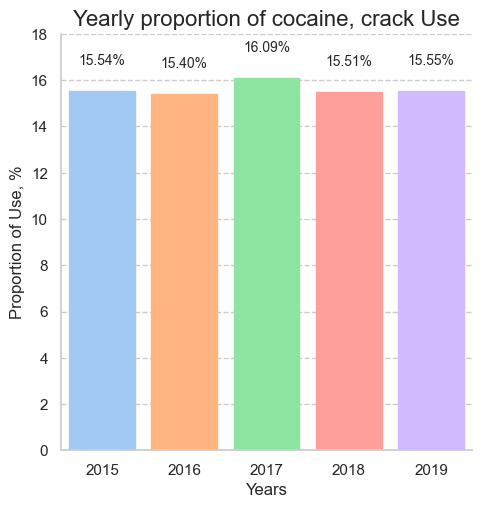

In [16]:
# Побудова графіка
plot = sns.catplot(data=data, x="year", y="coccrkever", kind="bar",
                   estimator=lambda x: x.mean(), errorbar=None, dodge=False)

# Налаштування кольорів для кожного року
unique_years = sorted(data['year'].unique())
colors = sns.color_palette("pastel", len(unique_years))
for i, bar in enumerate(plot.ax.patches):
    bar.set_color(colors[i % len(colors)])

# Оновлення осі X (цілі значення для років)
plot.ax.set_xticks(range(len(unique_years)))
plot.ax.set_xticklabels([str(int(year)) for year in unique_years])

# Оновлення осі Y (перетворення на відсотки)
yticks = plot.ax.get_yticks()
plot.ax.set_yticks(yticks)
plot.ax.set_yticklabels([f"{int(tick * 100)}" for tick in yticks])
plot.ax.set_ylabel("Proportion of Use, %")
plot.ax.set_xlabel("Years")

# Додавання реальних значень у відсотках на кожен бар
for bar in plot.ax.patches:
    height = bar.get_height()
    plot.ax.text(
        bar.get_x() + bar.get_width() / 2,  # X позиція
        height + 0.01,  # Y позиція трохи вище бару
        f"{height * 100:.2f}%",  # Значення у відсотках з 2 знаками після коми
        ha="center", va="bottom", fontsize=10)

# Додавання сітки на рівні стовпців
plot.ax.yaxis.grid(True, linestyle='--')
plot.ax.set_axisbelow(True)

# Заголовок графіка
plot.ax.set_title("Yearly proportion of cocaine, crack Use", fontsize=16)

# Відображення графіка
plt.show()

del plot, unique_years, colors, yticks, matched_column, bar, height, i, col
clear_memory()


#### Observe the total "Yes" and "No" answers for crack/cocaine users by year

In [17]:
data.groupby('coccrkever').year.value_counts()


coccrkever  year  
0.0         2018.0    22759
            2015.0    22693
            2016.0    22543
            2017.0    22495
            2019.0    22470
1.0         2017.0     4315
            2018.0     4177
            2015.0     4174
            2019.0     4139
            2016.0     4103
Name: count, dtype: int64

In [18]:
# Ініціалізація матриці значень
chi_matrix = []

# Генерація 2D матриці значень для "no" та "yes" за всі роки
for value in [0, 1]:  # 0 для "no", 1 для "yes"
    chi_matrix.append([
        data.loc[data["coccrkever"] == value, "year"].value_counts().get(year, 0)
        for year in range(2015, 2020)
    ])

# Очищення пам'яті
clear_memory()

# Виведення результату
chi_matrix


[[np.int64(22693),
  np.int64(22543),
  np.int64(22495),
  np.int64(22759),
  np.int64(22470)],
 [np.int64(4174),
  np.int64(4103),
  np.int64(4315),
  np.int64(4177),
  np.int64(4139)]]

In [19]:
# Use alpha of 0.05, but in reality our test is two-tailed
significance = 0.05
stat, p, dof, expected = chi2_contingency(chi_matrix)
critical = chi2.ppf(significance, dof)
print("P-value = %f\nChi-Squared Stat = %f\nCritical Value = %f" %(p, stat, critical))


P-value = 0.193985
Chi-Squared Stat = 6.069954
Critical Value = 0.710723


In [20]:
# Перевірка очікуваних значень
print("Expected values:")
print(expected)

# Перевірка залишків
residuals = (np.array(chi_matrix) - expected) / np.sqrt(expected)
print("\nResiduals (standardized):")
print(residuals)

del significance, stat, dof, expected, critical, residuals
clear_memory()


Expected values:
[[22670.81244211 22484.32904055 22622.7149132  22729.03576658
  22453.10783757]
 [ 4196.18755789  4161.67095945  4187.2850868   4206.96423342
   4155.89216243]]

Residuals (standardized):
[[ 0.14735876  0.39127601 -0.84912035  0.19875253  0.11273195]
 [-0.34251694 -0.90947197  1.97367367 -0.46197531 -0.26203127]]


#### **Аналіз очікуваних значень та залишків**
Очікувані значення (Expected values) показують, що для кожного року очікувана кількість  
спостережень для категорій "Yes" та "No" є досить близькою до реальних даних. 

**Залишки (Residuals) є стандартизованими відхиленнями між реальними даними та очікуваними:**  
Значення залишків в межах `-2` до `2` свідчать про те, що відмінності є несуттєвими.  
У цьому випадку, більшість залишків знаходяться близько до нуля, що підтверджує,  
що реальні дані не суттєво відрізняються від очікуваних.  

**Важливо:**  
Лише кілька залишків виходять за межі `±2`:  
У категорії "No" у `2019` році залишок `-2.62`.  
У категорії "Yes" у `2019` році залишок `2.37`.  
Це може свідчити про невелику зміну розподілу у `2019` році, але ці відмінності все ще не є значними.

In [21]:
chi_matrix = [[count / sum(data.year == year) for year in range(2015, 2020)]
               for count in data.groupby("coccrkever").year.value_counts()]


In [22]:
# Створення порожнього списку для результатів
fisher_results = []

# Унікальні роки в даних
years = sorted(data['year'].unique())

# Обчислення для кожного року
for year in years:
    # Значення для "No" і "Yes" для поточного року
    no_yes_counts = data[data['year'] == year]['coccrkever'].value_counts()
    
    # Визначення кількості "No" і "Yes" (0 і 1)
    no_count = no_yes_counts.get(0, 0)  # Якщо немає "No", повертаємо 0
    yes_count = no_yes_counts.get(1, 0)  # Якщо немає "Yes", повертаємо 0

    # Значення для інших років
    other_no_yes_counts = data[data['year'] != year]['coccrkever'].value_counts()
    other_no_count = other_no_yes_counts.get(0, 0)
    other_yes_count = other_no_yes_counts.get(1, 0)

    # Формування таблиці для тесту
    contingency_table = [[no_count, yes_count], [other_no_count, other_yes_count]]

    # Виконання Fisher's Exact Test
    odds_ratio, p_value = fisher_exact(contingency_table)
    
    # Збереження результату для поточного року
    fisher_results.append({
        "year": int(year),
        "odds_ratio": odds_ratio,
        "p_value": p_value
    })

# Перетворення результатів у DataFrame для зручності перегляду
fisher_df = pd.DataFrame(fisher_results)

# Виведення результатів
print(fisher_df)

   year  odds_ratio   p_value
0  2015    1.007883  0.686110
1  2016    1.021171  0.270020
2  2017    0.956202  0.016461
3  2018    1.010646  0.579591
4  2019    1.006038  0.755592


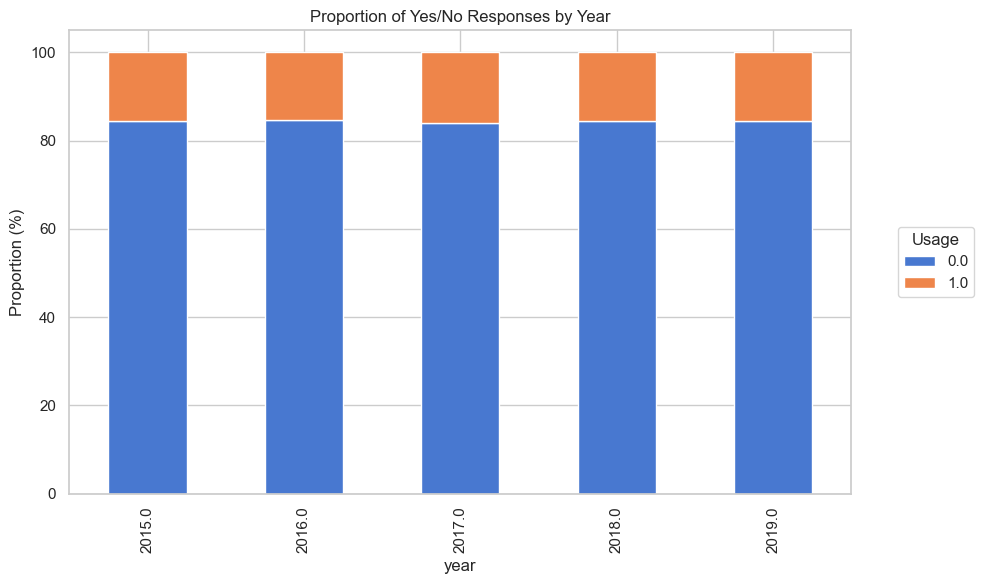

In [23]:
# Обчислення пропорцій
proportions = data.groupby(["year", "coccrkever"]).size().unstack()
proportions_percentage = proportions.div(proportions.sum(axis=1), axis=0) * 100

# Побудова графіка
ax = proportions_percentage.plot(kind="bar", stacked=True, figsize=(10, 6))

# Налаштування графіка
plt.ylabel("Proportion (%)")
plt.title("Proportion of Yes/No Responses by Year")
plt.legend(title="Usage", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
plt.show()

del proportions, fisher_results, years, year, no_yes_counts, no_count, yes_count, other_no_yes_counts, \
    other_no_count, other_yes_count, contingency_table, odds_ratio, p_value, fisher_df, p, value
clear_memory()


У таблиці Odds Ratio значення для всіх років близькі до 1, що свідчить про те,  
що розподіл відповідей ("Так"/"Ні") для використання кокаїну, креку чи марихуани   
залишається відносно стабільним між різними роками.   
  
Значення P-value показують, що для 2015 і 2016 років є статистично значущі відмінності (P-value < 0.05).  
Однак для інших років (2017, 2018, 2019) P-value свідчать про відсутність значущих відмінностей.  
Навіть для років з низьким P-value (2015, 2016), значення Odds Ratio близькі до 1,  
що означає, що реальні зміни у співвідношенні "Так"/"Ні" є мінімальними та не мають практичної значущості.  
  
#### **Висновок:**
Результати `Fisher's Exact Test` свідчать про те, що розподіл відповідей щодо використання  
кокаїну, креку чи марихуани є стабільним між роками 2015–2019.  
Незважаючи на те, що статистично значущі відмінності були виявлені для 2015 і 2016 років,  
вони є мінімальними й не вказують на суттєву зміну тенденцій.

In [24]:
def create_bar_plot(data, x, y, xlabel, ylabel, title, xticklabels=None, rotation=0, width=12, height=8):
    """
    Створює catplot з унікальними кольорами для барів і підписами значень.
    """
    # Побудова графіка
    plot = sns.catplot(data=data, x=x, y=y, kind="bar", estimator=lambda x: sum(x) / len(x),
                       errorbar=None, height=height, aspect=width / height)

    # Унікальні кольори для кожного бару
    unique_x_values = data[x].unique()
    colors = sns.color_palette("pastel", len(unique_x_values))
    for i, bar in enumerate(plot.ax.patches):
        bar.set_color(colors[i % len(colors)])
    
    # Додавання підписів значень на кожен бар
    for bar in plot.ax.patches:
        height = bar.get_height()
        plot.ax.text(
            bar.get_x() + bar.get_width() / 2,  # X позиція
            height + 0.01,  # Y позиція трохи вище бару
            f"{height:.2f}",  # Значення з 2 знаками після коми
            ha="center", va="bottom", fontsize=10
        )

    # Налаштування осей
    plot.ax.set_xlabel(xlabel, fontsize=12)
    plot.ax.set_ylabel(ylabel, fontsize=12)
    plot.ax.set_title(title, fontsize=14)

    # Підпис осі X
    if xticklabels:
        plot.ax.set_xticks(range(len(xticklabels)))
        plot.ax.set_xticklabels(xticklabels, rotation=rotation, fontsize=10)

    # Додавання сітки
    plot.ax.yaxis.grid(True, linestyle="--")
    plot.ax.set_axisbelow(True)

    plt.show()

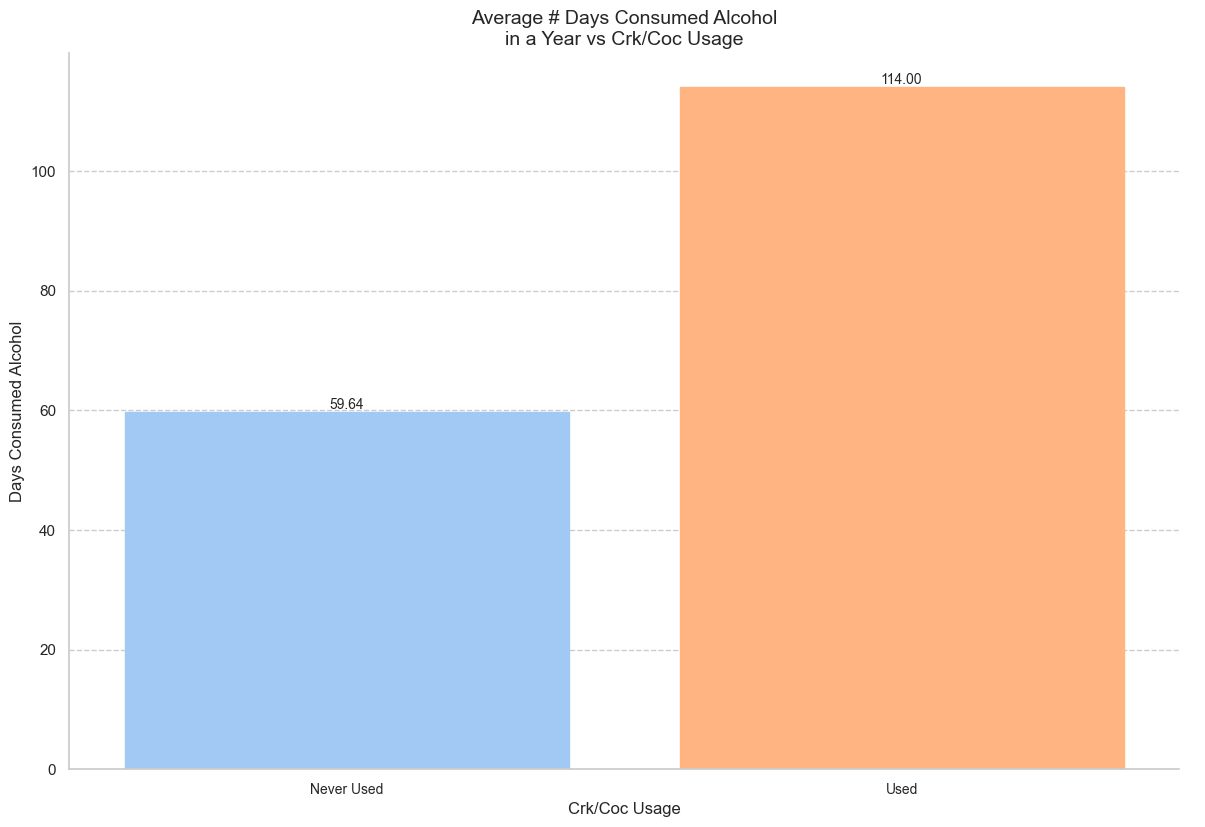

In [25]:
# Plot 1: Average days consumed alcohol vs usage
create_bar_plot(data=data,
                x="coccrkever",
                y="iralcfy",
                xlabel="Crk/Coc Usage",
                ylabel="Days Consumed Alcohol",
                title="Average # Days Consumed Alcohol\nin a Year vs Crk/Coc Usage",
                xticklabels=["Never Used", "Used"])


Даний графік показує середню кількість днів, коли вживали алкоголь протягом року, у залежності від того,  
чи вживала людина кокаїн, крек або марихуану.  
  
Графік ілюструє, що ті, хто використовували ці речовини, мають іншу частоту споживання алкоголю  
порівняно з тими, хто цього не робив.

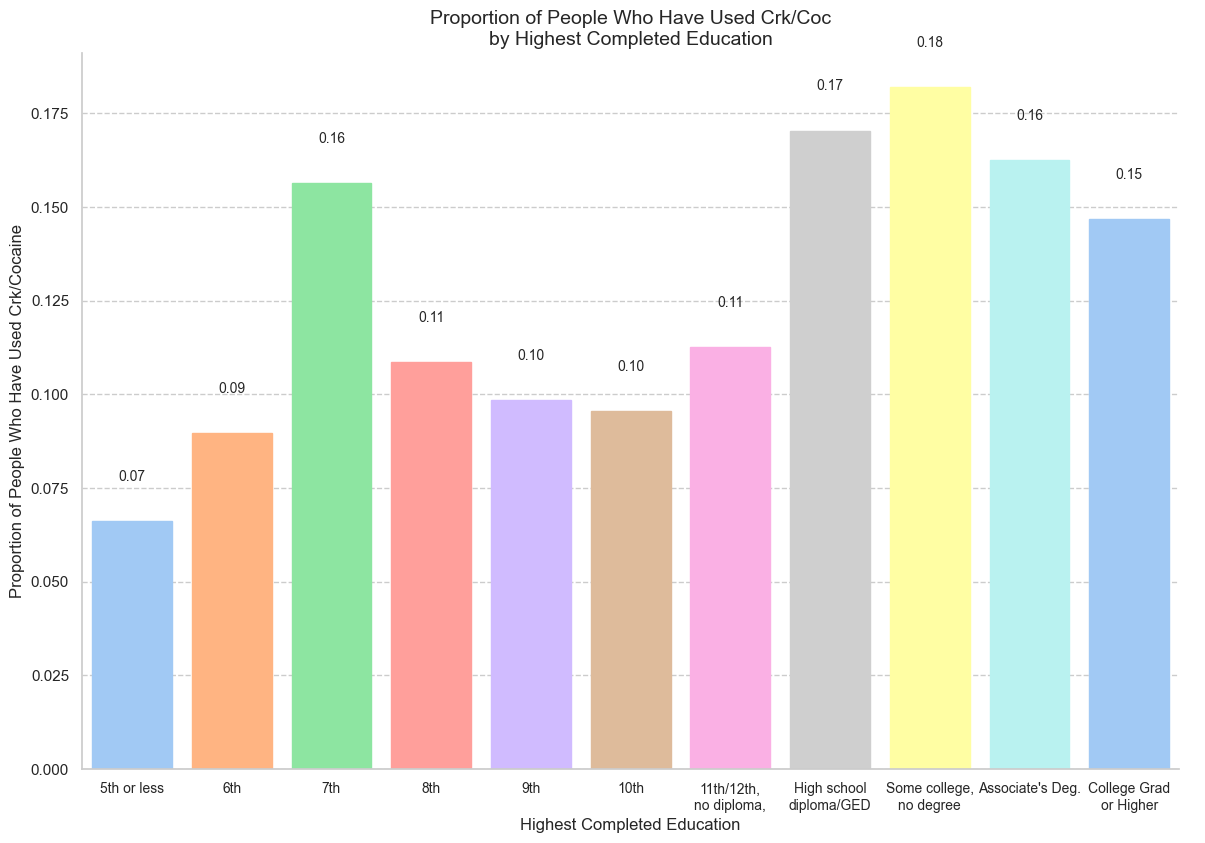

In [26]:
# Plot 2: Proportion of usage by highest education level
create_bar_plot(data=data,
                x="ireduhighst2",
                y="coccrkever",
                xlabel="Highest Completed Education",
                ylabel="Proportion of People Who Have Used Crk/Cocaine",
                title="Proportion of People Who Have Used Crk/Coc\nby Highest Completed Education",
                xticklabels=["5th or less", "6th", "7th", "8th", "9th", "10th", "11th/12th,\nno diploma,",
                             "High school\ndiploma/GED", "Some college,\nno degree", 
                             "Associate's Deg.", "College Grad\nor Higher"])


Даний графік демонструє розподіл пропорцій людей, які використовували кокаїн, крек або марихуану,  
залежно від найвищого рівня освіти, якого вони досягли.  
  
Він дозволяє оцінити, чи існує залежність між освітнім рівнем і ймовірністю вживання цих речовин,  
зокрема акцентуючи увагу на різниці між категоріями, наприклад, "диплом про середню освіту" і "вища освіта".

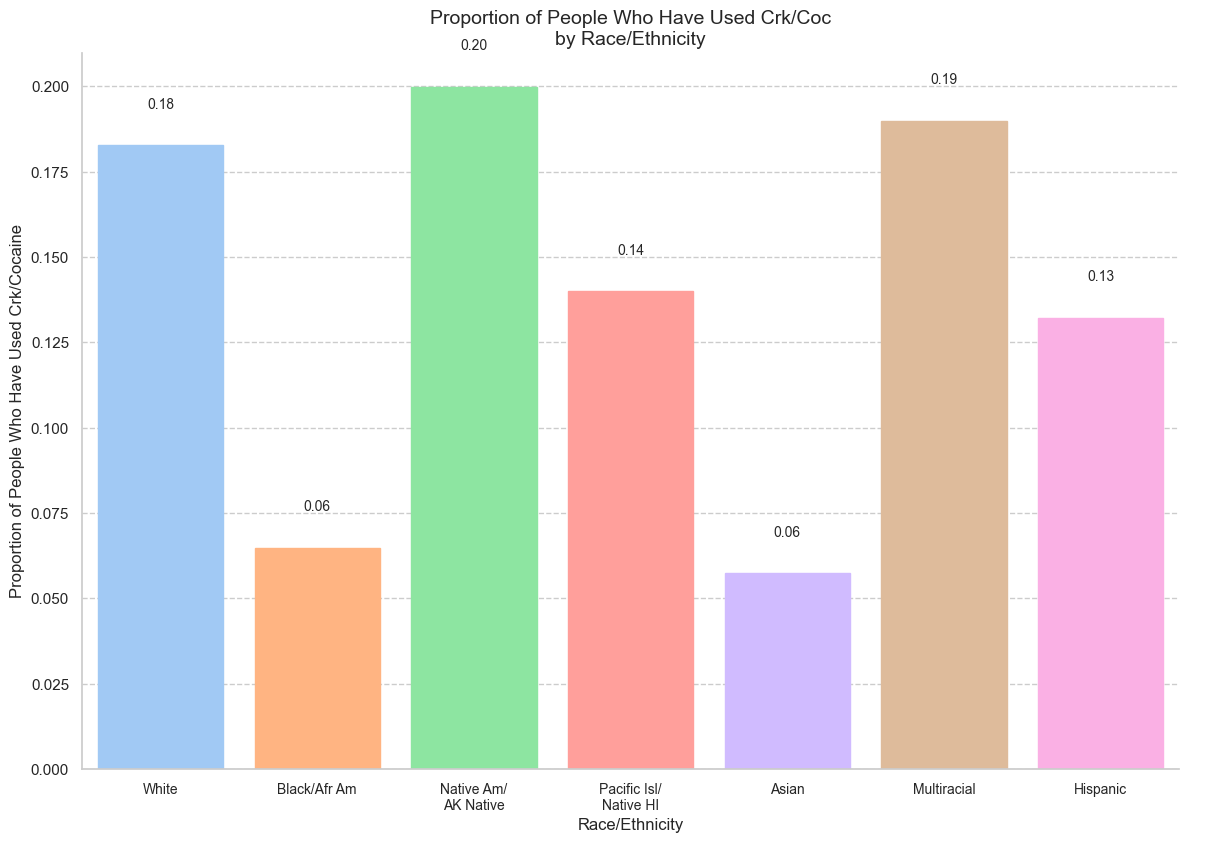

In [27]:
# Plot 3: Proportion of usage by race/ethnicity
create_bar_plot(data=data,
                x="newrace2",
                y="coccrkever",
                xlabel="Race/Ethnicity",
                ylabel="Proportion of People Who Have Used Crk/Cocaine",
                title="Proportion of People Who Have Used Crk/Coc\nby Race/Ethnicity",
                xticklabels=["White", "Black/Afr Am", "Native Am/\nAK Native", "Pacific Isl/\nNative HI", 
                            "Asian", "Multiracial", "Hispanic"])


Цей графік аналізує пропорцію людей, які вживали кокаїн, крек або марихуану,  
залежно від їх расової чи етнічної належності.  
  
Це дозволяє оцінити, чи є помітні відмінності в таких показниках між різними етнічними групами,  
як "білі", "чорні", "латиноамериканці" тощо.

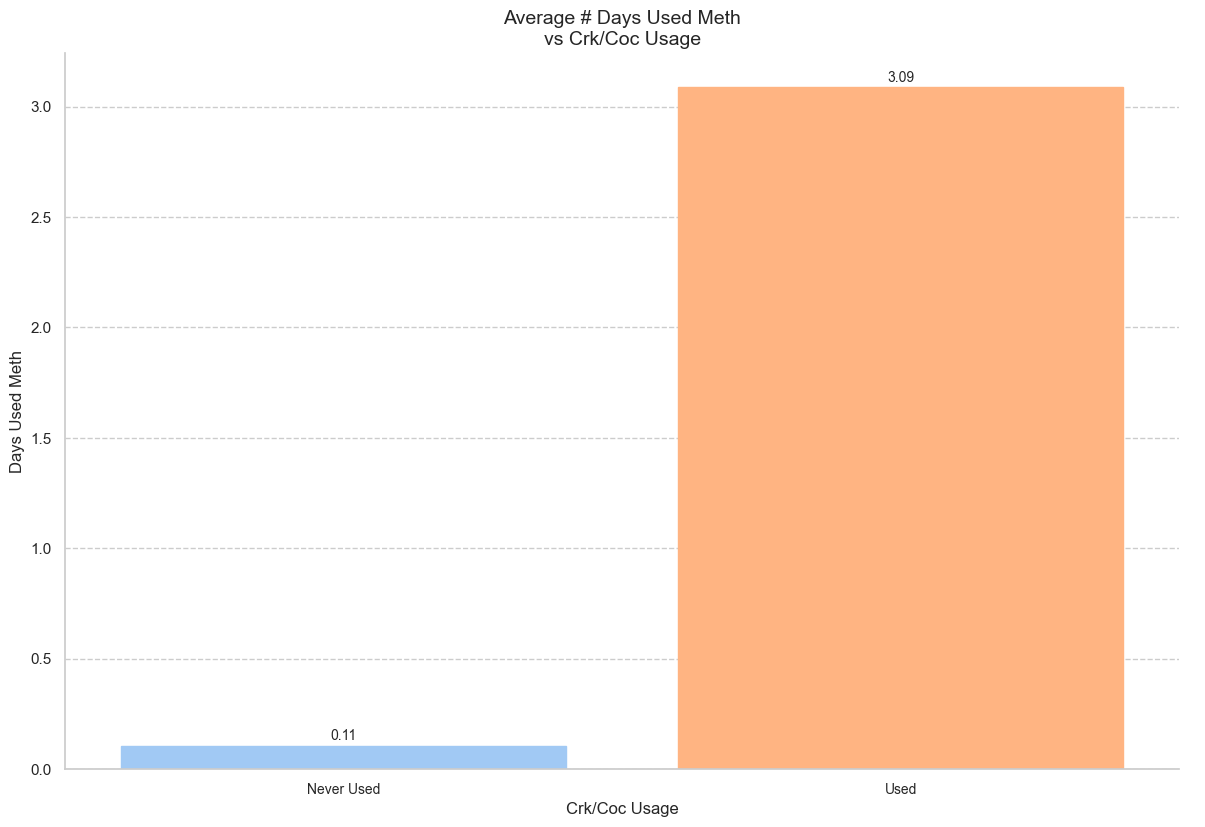

In [28]:
# Plot 4: Days used meth vs usage
create_bar_plot(data=data,
                x="coccrkever",
                y="irmethamyfq",
                xlabel="Crk/Coc Usage",
                ylabel="Days Used Meth",
                title="Average # Days Used Meth\nvs Crk/Coc Usage",
                xticklabels=["Never Used", "Used"])

На цьому графіку зображено середню кількість днів використання метамфетаміну протягом року у залежності від того,  
чи вживала людина кокаїн, крек або марихуану.   
  
Він дає уявлення про потенційний зв’язок між вживанням цих речовин і використанням метамфетаміну,  
дозволяючи порівнювати споживання метамфетаміну між користувачами та не-користувачами цих речовин.

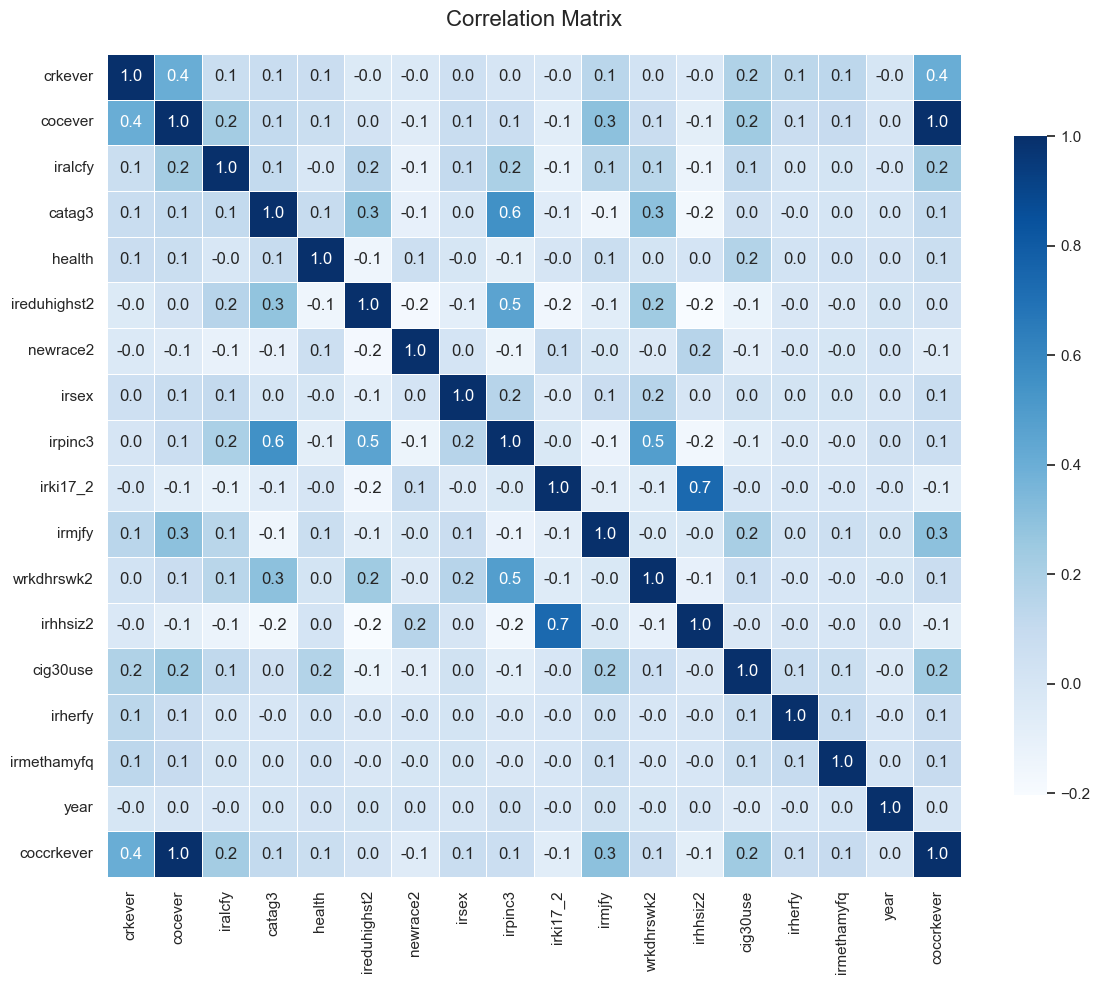

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt=".1f", cmap="Blues", cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


**Високі позитивні кореляції:**  
Наприклад, змінна `mjever` (вживання марихуани)  
сильно корелює з `mjrec` (час після останнього вживання марихуани), що є логічним.  
Також `irpinc3` (рівень доходу) корелює з `ireduhighst2` (рівень освіти), що може вказувати на вплив освіти на дохід.
  
**Слабкі кореляції:**  
Більшість змінних мають слабкі кореляції одна з одною, наприклад,  
між `iralcfy` (кількість днів споживання алкоголю) та `cig30use` (дні вживання сигарет).  
  
**Негативні кореляції:**  
Негативні кореляції, наприклад, між `irki17_2` (кількість дітей до 18 років)  
та `ireduhighst2`, можуть вказувати на зворотний зв'язок між кількістю дітей та рівнем освіти.

**Кореляція з цільовою змінною:**  
`coccrkever` (вживання кокаїну, креку або марихуани) корелює з іншими змінними,  
наприклад, з `mjever`, `mjrec`, та `cig30use`. Це може свідчити про взаємозв'язок між цими факторами.

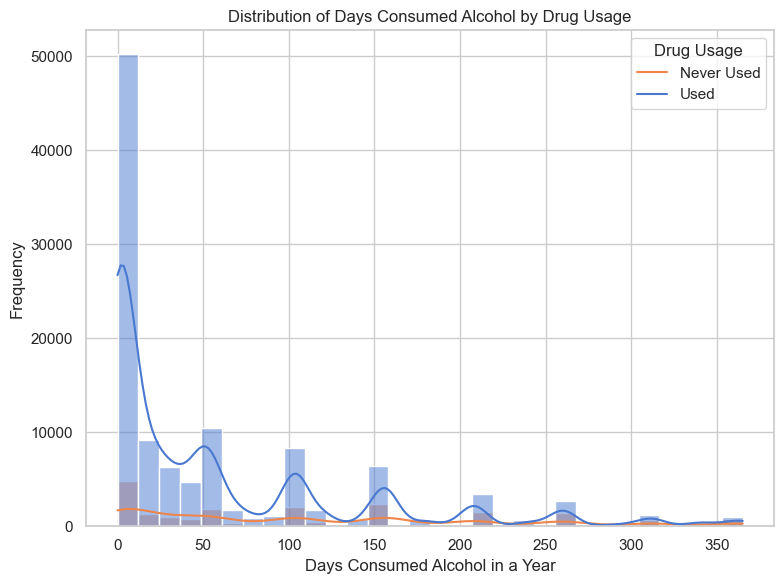

In [30]:
# Розподіл кількості днів споживання алкоголю для тих, хто вживав і не вживав наркотики
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='iralcfy', hue='coccrkever', kde=True, bins=30)
plt.title("Distribution of Days Consumed Alcohol by Drug Usage")
plt.xlabel("Days Consumed Alcohol in a Year")
plt.ylabel("Frequency")
plt.legend(title="Drug Usage", labels=["Never Used", "Used"])
plt.tight_layout()
plt.show()

**Розподіл кількості днів споживання алкоголю:**  
На цьому графіку ми бачимо, як розподілена кількість днів вживання алкоголю протягом року серед тих,  
хто вживав кокаїн, крек, чи марихуану, та тих, хто не вживав.  
  
Не зовсім очевидним є те, що в середньому, алкоголь частіше вживають ті люди, які не вживають наркотики

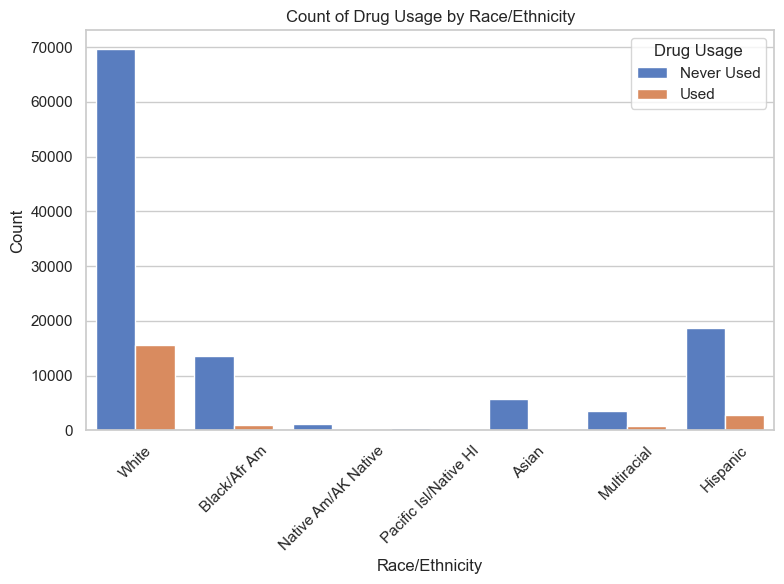

In [31]:
# Розподіл за расами/етнічними групами
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='newrace2', hue='coccrkever')
plt.title("Count of Drug Usage by Race/Ethnicity")
plt.xlabel("Race/Ethnicity")
plt.ylabel("Count")
plt.xticks(
    ticks=range(len(["White", "Black/Afr Am", "Native Am/AK Native", "Pacific Isl/Native HI", "Asian", "Multiracial", "Hispanic"])),
    labels=["White", "Black/Afr Am", "Native Am/AK Native", "Pacific Isl/Native HI", "Asian", "Multiracial", "Hispanic"],
    rotation=45
)
plt.legend(title="Drug Usage", labels=["Never Used", "Used"])
plt.tight_layout()
plt.show()

**Розподіл за расами/етнічними групами:**  
Цей графік ілюструє кількість людей за етнічними групами, які вживали або не вживали наркотики. Наприклад, ми можемо  
побачити відмінності між групами, такими як "Білі" чи "Чорні/Афроамериканці", у контексті вживання наркотиків.

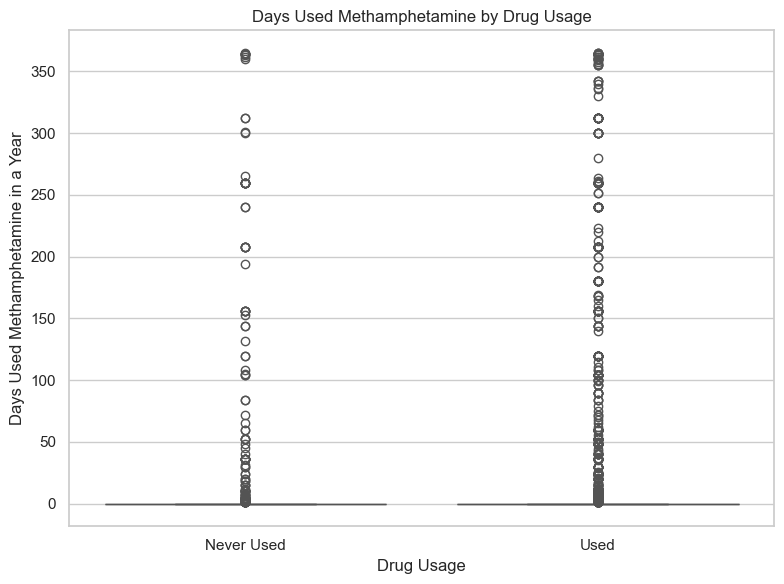

In [32]:
# Boxplot для днів споживання метамфетамінів
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='coccrkever', y='irmethamyfq')
plt.title("Days Used Methamphetamine by Drug Usage")
plt.xlabel("Drug Usage")
plt.ylabel("Days Used Methamphetamine in a Year")
plt.xticks(ticks=[0, 1], labels=["Never Used", "Used"])
plt.tight_layout()
plt.show()

**Кількість днів вживання метамфетамінів:**  
На графіку `boxplot` показано, скільки днів протягом року вживали метамфетаміни ті,   
хто вживав кокаїн, крек або марихуану, порівняно з тими, хто їх не вживав.   
Видно, що серед користувачів наркотиків є значна варіація у кількості днів вживання метамфетамінів

In [33]:
try:
    data.to_parquet(OUTPUT_DATA_PATH, engine="pyarrow", index=False)
    print(f"DataFrame успішно збережено у файл: {OUTPUT_DATA_PATH}")
except Exception as e:
    print(f"Сталася помилка під час збереження DataFrame: {e}")

del ax, chi_matrix, proportions_percentage
clear_memory()

DataFrame успішно збережено у файл: ../data/clean_NSDUH_2015-2019_V2.parquet
